<a href="https://colab.research.google.com/github/anonymous0897/ICML_Draft/blob/main/Fine_Tuning_Heart_Disease_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Fine-Tuning for Predicting Heart Disease Risk:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C53919):

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)



In [4]:
data = cdc_diabetes_health_indicators.data
# data (as pandas dataframes)
X = data.features
y = data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [5]:
X.iloc[:,6]

,HeartDiseaseorAttack
0,0
1,0
2,0
3,0
4,0
...,...
253675,0
253676,0
253677,0
253678,0


In [6]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [7]:
data2 = pd.concat([X_scaled, y], axis=1)
data2

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714,0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000,0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000,0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143,0
253676,1.0,1.0,1.0,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.75,0.0,0.000000,1.0,0.0,0.833333,0.2,0.428571,1
253677,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857,0
253678,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000,0


In [8]:
y.value_counts()

,count
Diabetes_binary,
0,218334
1,35346


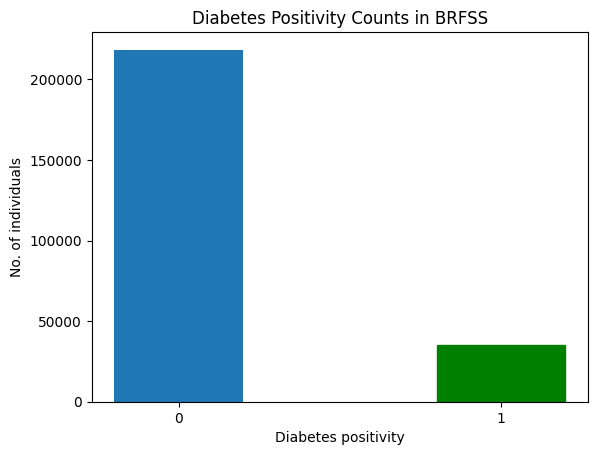

In [9]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS")
plt.show()

# Splitting for Source and Target Domains:


# Full Dataset:

For the Heart Disease prediction, we split the dataset between low education level (**now including high-school dropouts**) and the high education level. The high-education data (with diabetes as response variable/label) becomes the source data and the low-education data (with Heart Disease as response variable/label) is the target data.

In [10]:
data_S = data2[data2[19] >= 0.5]  ## Source domain and classification
data_S_X = data_S.drop(data_S.columns[[6, 21]], axis=1)
data_S_y = data_S.iloc[:, 21]    ## Response variable of interest is Diabetes

data_S_full = pd.concat([data_S_X, data_S_y], axis=1)

data_T = data2[data2[19] < 0.5]

data_T_X = data_T.drop(data_T.columns[[6, 21]], axis=1)
data_T_y = data_T.iloc[:, 6]    ## Response variable of interest in Heart Disease

data_T_full = pd.concat([data_T_X, data_T_y], axis=1)

In [11]:
data_T_full

,0,1,2,3,4,5,7,8,9,10,...,12,13,14,15,16,17,18,19,20,6
3,1.0,0.0,1.0,0.174419,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0.0
21,1.0,1.0,1.0,0.302326,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.00,0.5,1.000000,1.0,0.0,1.000000,0.2,0.285714,0.0
27,1.0,1.0,1.0,0.186047,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.75,0.0,0.000000,0.0,1.0,0.916667,0.2,0.428571,1.0
31,1.0,0.0,1.0,0.244186,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,1.0,1.0,1.000000,0.4,0.285714,0.0
34,1.0,1.0,1.0,0.139535,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.916667,0.4,0.285714,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253668,0.0,1.0,1.0,0.197674,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.25,0.0,0.000000,1.0,1.0,0.750000,0.4,0.714286,1.0
253669,0.0,1.0,1.0,0.174419,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.00,0.0,0.100000,0.0,1.0,0.416667,0.2,0.428571,0.0
253671,1.0,1.0,1.0,0.127907,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.75,0.0,0.166667,0.0,1.0,0.583333,0.4,0.142857,1.0
253672,1.0,0.0,1.0,0.209302,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.916667,0.2,0.000000,1.0


## Source domain and task labels:

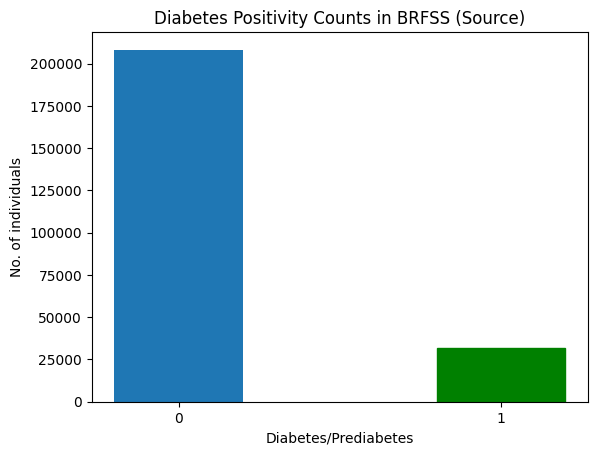

In [12]:
barlist_S = plt.bar([str(0),str(1)], data_S_y.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Diabetes/Prediabetes")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Source)")
plt.show()

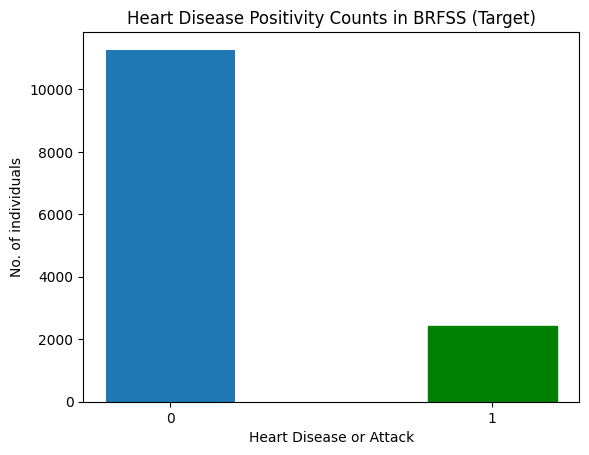

In [13]:
barlist_T = plt.bar([str(0),str(1)], data_T_y.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Heart Disease or Attack")
plt.ylabel("No. of individuals")
plt.title("Heart Disease Positivity Counts in BRFSS (Target)")
plt.show()

## DNN and Fine-tuning Algorithms:

In [14]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  model.summary()
  print(len(model.layers))

  return model


def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    model.save('model.h5')
    model.save_weights('model_wt.weights.h5')

    return model


In [15]:
def train_and_evaluate_nosave(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    return model


In [16]:
def fine_tuning(X_train, X_test, y_train, y_test, llim, ulim):
    new_model = create_dnn_model(X_S_train.shape[1])
    # new_model = tf.keras.models.load_model('model.h5')
    new_model.load_weights('model_wt.weights.h5')

    for layer in new_model.layers[llim:ulim]:
        layer.trainable = False
    for layer in new_model.layers[-1:]:
        layer.trainable = False

    for layer in new_model.layers:
        if layer.trainable == True:
          print("Trainable")
        else:
          print("Not Trainable")

    train_and_evaluate_nosave(new_model, X_train, X_test, y_train, y_test, "Target")

In [17]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

# Over/undersampling functions:

## Undersampling functions:

In [28]:
import random

def SRS_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=False)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :20]
    y_SRS = data_SRS_RUS.iloc[:, 20]

    return X_SRS, y_SRS


def SRSwR_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_maj_rus = data_majority.sample(n=undersample_size, replace=True)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS = data_SRS_RUS.iloc[:, :20]
    y_SRS = data_SRS_RUS.iloc[:, 20]

    return X_SRS, y_SRS


def systematic_undersampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.randint(1, int(k))
    print(start)
    Row = []
    for i in range(undersample_size):
      row = start+int(k*i)-1
      Row.append(row)
    # print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :20]
    y_Sy = data_Sy_RUS.iloc[:, 20]

    return X_Sy, y_Sy



def multi_systematic_undersampler(data, data_column, m):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)
    print(undersample_size)
    print(oversample_size)

    k = oversample_size/undersample_size
    print(k)
    np.random.seed(123)
    start = random.sample(range(1, int(k*m)), m)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/m)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    # print(Row)
    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]
    data_maj_rus
    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])

    X_Sy = data_Sy_RUS.iloc[:, :20]
    y_Sy = data_Sy_RUS.iloc[:, 20]

    return X_Sy, y_Sy

## Oversampling functions:

In [19]:
def SRSwR_oversampler(data, data_column):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    np.random.seed(123)
    data_min_ros = data_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_SRS_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_SRS = data_SRS_ROS.iloc[:, :20]
    y_SRS = data_SRS_ROS.iloc[:, 20]

    return X_SRS, y_SRS

# data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)


def systematic_resampler(data, data_column, k):
    data_majority = data[data_column.isin([0])]
    data_minority = data[data_column.isin([1])]
    undersample_size = len(data_minority)
    oversample_size = len(data_majority)

    print(undersample_size)
    print(oversample_size)

    Nsamples = k*(oversample_size-undersample_size)/undersample_size
    print('Nsamples=', Nsamples)

    np.random.seed(123)
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for i in range(int(undersample_size/k)):
        row = start[j]+int(k*i)-1
        Row.append(row)
    data_min_ros = pd.DataFrame()
    data_min_ros = data_minority.iloc[Row]

    data_Sy_ROS = pd.concat([data_majority, data_minority, data_min_ros])
    X_Sy = data_Sy_ROS.iloc[:, :20]
    y_Sy = data_Sy_ROS.iloc[:, 20]

    return X_Sy, y_Sy


In [20]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(data_S_X, data_S_y, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)

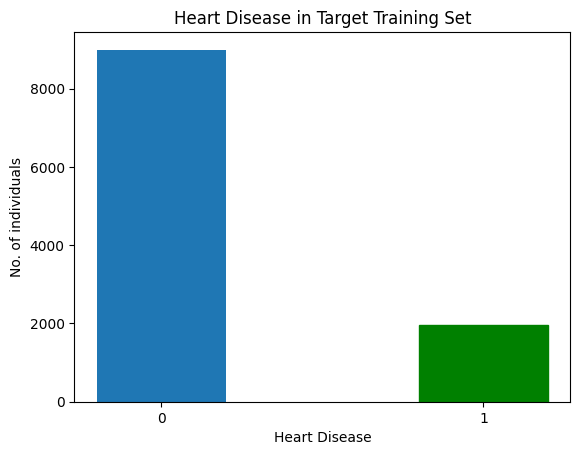

In [21]:
barlist = plt.bar([str(0),str(1)], y_T_train.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Heart Disease")
plt.ylabel("No. of individuals")
plt.title("Heart Disease in Target Training Set")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (191988, 20)
y_S_train: (191988,)
X_S_test: (47997, 20)
y_S_test: (47997,)


# Original (Imbalanced) dataset:

## Standard Machine Learning:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - AUC: 0.5690 - loss: 0.4867 - val_AUC: 0.7496 - val_loss: 0.4207
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7588 - loss: 0.3988 - val_AUC: 0.7654 - val_loss: 0.4113
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7772 - loss: 0.3952 - val_AUC: 0.7705 - val_loss: 0.4097
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7881 - loss: 0.3862 - val_AUC: 0.7670 - val_loss: 0.4111
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7771 - loss: 0.3857 - val_AUC: 0.7648 - val_loss: 0.4156
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7991 - loss: 0.3802 - val_AUC: 0.7691 - val_loss: 0.4094
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8008 - loss: 0.3725 - val_AUC: 0.7642 - val_loss: 0.4133
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8058 - loss: 0.3752 - val_AUC: 0.7660 - val_loss: 0.4177
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

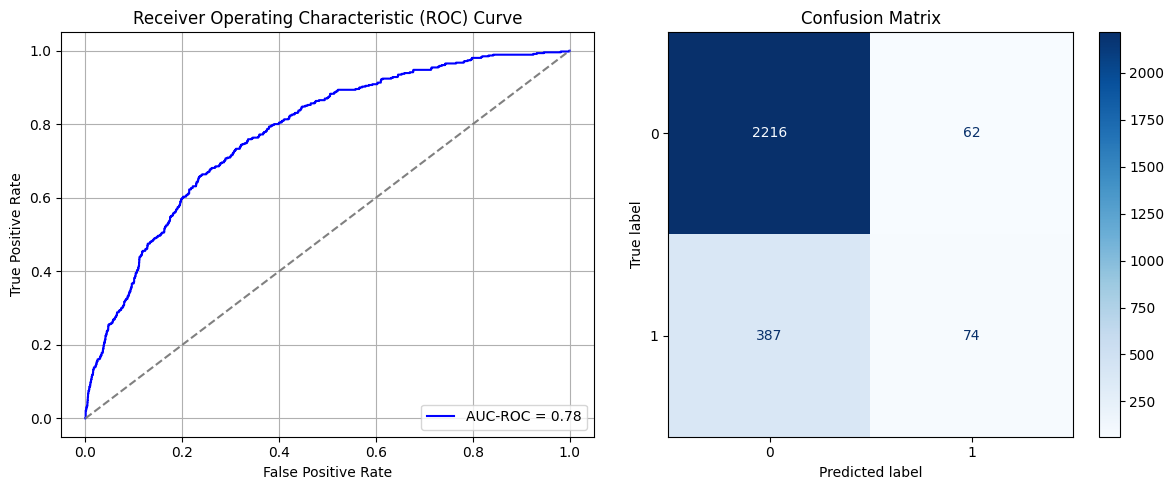

<ipython-input-14-ee81dc70d85c>:78: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold based on F1-score: 0.731277346611023
Time elapsed (performance): 28.568629295999926


<Sequential name=sequential, built=True>

In [ ]:
model_source = create_dnn_model(X_S_train.shape[1])
train_and_evaluate(model_source, X_T_train, X_T_test, y_T_train, y_T_test, "Target")

## With Transfer Learning:

In [ ]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - AUC: 0.7840 - loss: 0.3273 - val_AUC: 0.8207 - val_loss: 0.3183
Epoch 2/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.8189 - loss: 0.3093 - val_AUC: 0.8230 - val_loss: 0.3146
Epoch 3/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8199 - loss: 0.3077 - val_AUC: 0.8246 - val_loss: 0.3142
Epoch 4/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8239 - loss: 0.3054 - val_AUC: 0.8245 - val_loss: 0.3123
Epoch 5/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8255 - loss: 0.3024 - val_AUC: 0.8254 - val_loss: 0.3111
Epoch 6/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - AUC: 0.8239 - loss: 0.3069 - val_AUC: 0.8251 - val_loss: 0.3120
Epoch 7/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.8289 - loss: 0.3005 - val_AUC: 0.8257 - val_loss: 0.3134
Epoch 8/10
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8289 - loss: 0.3031 - val_AUC: 0.8254 - val_loss: 0.3113
Epoch 9/10
4800/4800 ━━━━━━━━━━━

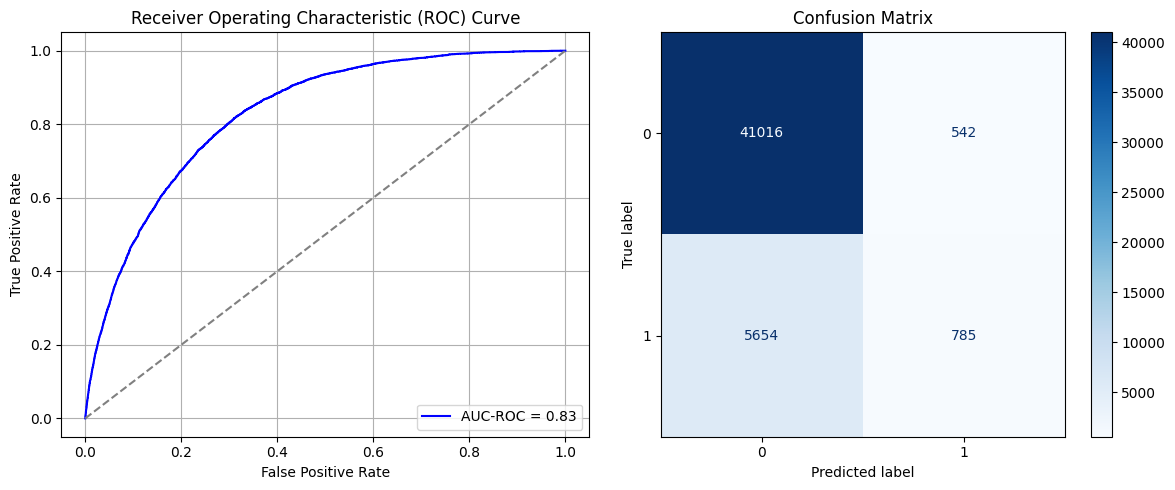

Best threshold based on F1-score: 0.20638151466846466
Time elapsed (performance): 191.49761221800009


<Sequential name=sequential_1, built=True>

In [ ]:
train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")
# model_source.save('model_source.h5')
# model_source.save_weights('model_wt.weights.h5')

In [ ]:
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC-ROC: 0.6988443643718374
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      2278
         1.0       0.32      0.13      0.19       461

    accuracy                           0.81      2739
   macro avg       0.58      0.54      0.54      2739
weighted avg       0.75      0.81      0.77      2739

FPR 0.05706760316066725 TPR: 0.13232104121475052 FNR: 0.8676789587852495 TNR: 0.9429323968393327


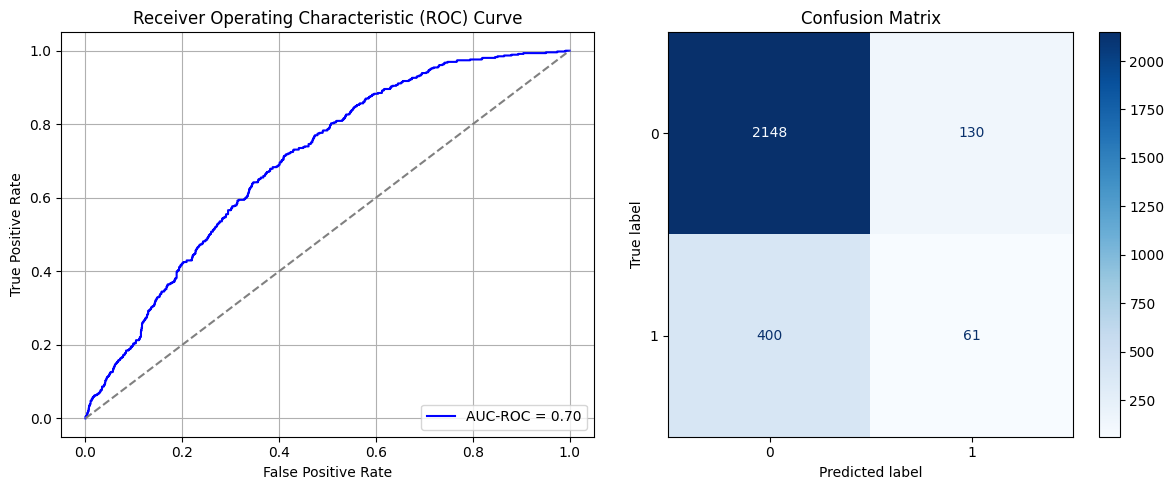

Best threshold based on F1-score: 0.24184900522232056
False Negative Rate: 0.8676789587852495
Time elapsed (performance): 0.8317298350000328


In [ ]:
Transductive_TL(model_source, X_T_test, y_T_test, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - AUC: 0.7062 - loss: 0.4378 - val_AUC: 0.6815 - val_loss: 0.4483
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7001 - loss: 0.4307 - val_AUC: 0.6810 - val_loss: 0.4472
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7098 - loss: 0.4126 - val_AUC: 0.6810 - val_loss: 0.4458
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7078 - loss: 0.4293 - val_AUC: 0.6813 - val_loss: 0.4460
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6972 - loss: 0.4294 - val_AUC: 0.6816 - val_loss: 0.4455
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6967 - loss: 0.4331 - val_AUC: 0.6807 - val_loss: 0.4464
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6989 - loss: 0.4359 - val_AUC: 0.6805 - val_loss: 0.4464
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7001 - loss: 0.4370 - val_AUC: 0.6813 - val_loss: 0.4459
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7051 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


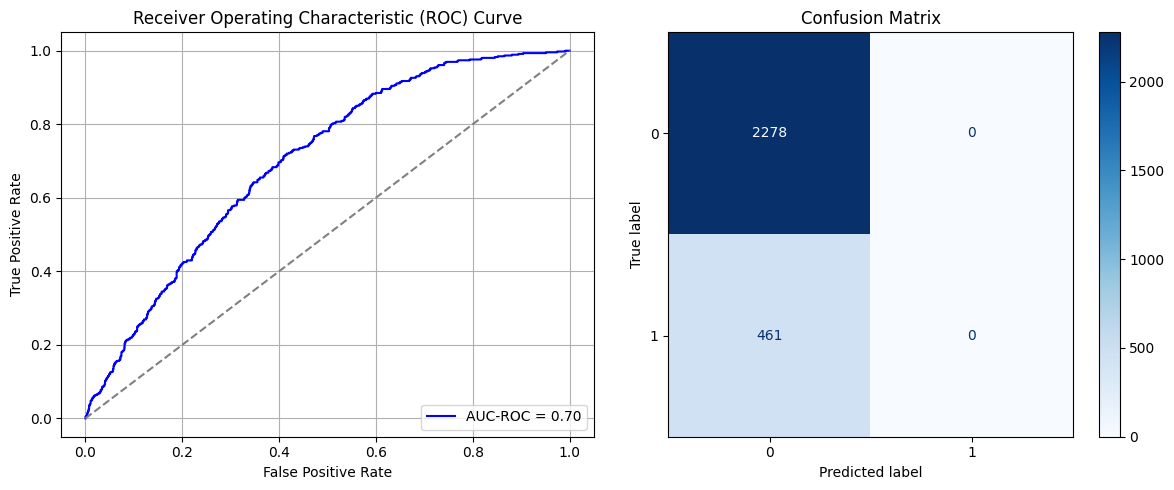

Best threshold based on F1-score: 0.215129554271698
Time elapsed (performance): 14.169311304999837


In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [ ]:
X_S_SRS, y_S_SRS = SRS_undersampler(data_S_full, data_S_full['Diabetes_binary'])
print(y_S_SRS)

31820
208165
74675     0
74495     0
183000    0
172231    0
47797     0
         ..
253630    1
253636    1
253659    1
253670    1
253679    1
Name: Diabetes_binary, Length: 63640, dtype: int64


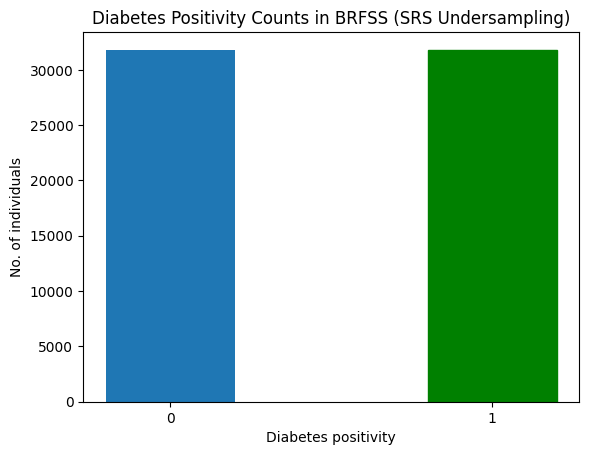

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Undersampling)")
plt.show()

In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRS, y_T_train_SRS = SRS_undersampler(T_train, T_train[6])
print(y_T_train_SRS)


1964
8992
171682    0.0
212930    0.0
176967    0.0
68316     0.0
253412    0.0
         ... 
47021     1.0
197392    1.0
59357     1.0
156689    1.0
45219     1.0
Name: 6, Length: 3928, dtype: float64


In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50912, 20)
y_S_train: (50912,)
X_S_test: (12728, 20)
y_S_test: (12728,)


In [ ]:
model_source_SRS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_150 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_151 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7828 - loss: 0.5569 - val_AUC: 0.8153 - val_loss: 0.5270
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8185 - loss: 0.5157 - val_AUC: 0.8186 - val_loss: 0.5181
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8237 - loss: 0.5092 - val_AUC: 0.8185 - val_loss: 0.5342
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8193 - loss: 0.5159 - val_AUC: 0.8184 - val_loss: 0.5184
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8219 - loss: 0.5120 - val_AUC: 0.8195 - val_loss: 0.5249
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8259 - loss: 0.5072 - val_AUC: 0.8208 - val_loss: 0.5161
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8217 - loss: 0.5115 - val_AUC: 0.8214 - val_loss: 0.5159
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8269 - loss: 0.5052 - val_AUC: 0.8222 - val_loss: 0.5140
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━━

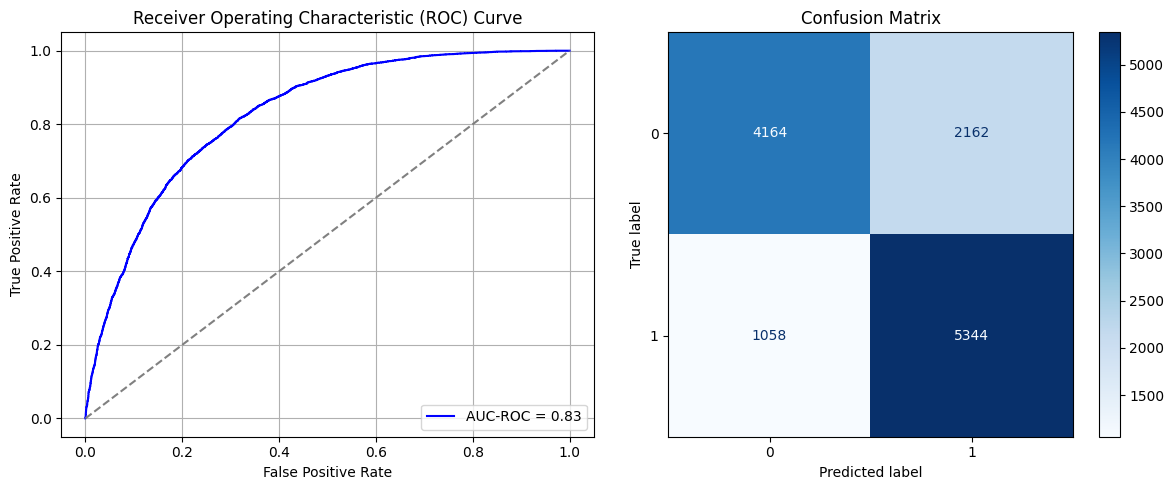

<ipython-input-14-ee81dc70d85c>:78: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold based on F1-score: 0.9682676196098328
Time elapsed (performance): 50.778444662999846


<Sequential name=sequential_21, built=True>

In [ ]:
train_and_evaluate(model_source_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC-ROC: 0.7278790429630589
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.37      0.54      2278
         1.0       0.23      0.92      0.37       461

    accuracy                           0.46      2739
   macro avg       0.59      0.65      0.45      2739
weighted avg       0.84      0.46      0.51      2739

FPR 0.6273046532045654 TPR: 0.9197396963123644 FNR: 0.08026030368763558 TNR: 0.3726953467954346


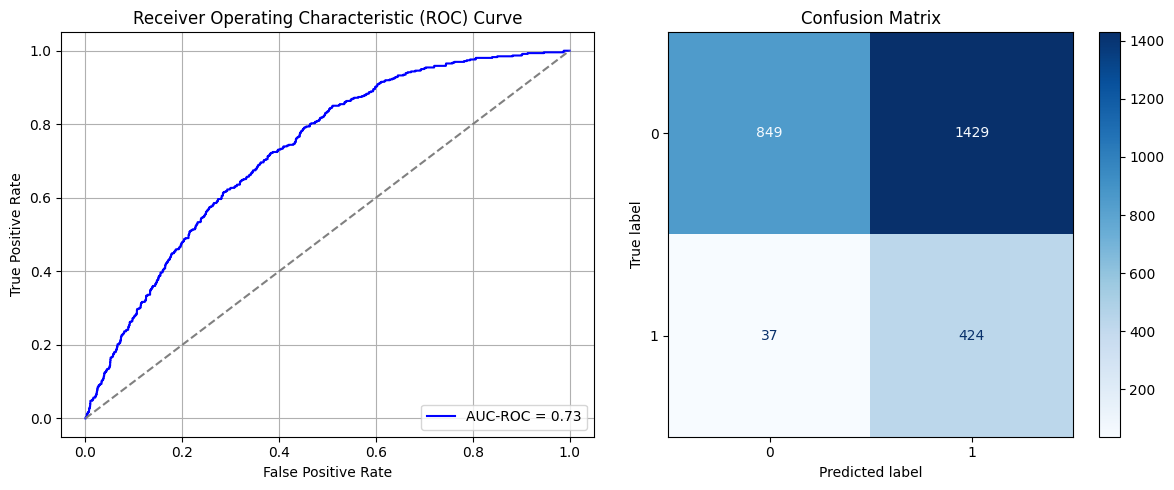

Best threshold based on F1-score: 0.7461060881614685
False Negative Rate: 0.08026030368763558
Time elapsed (performance): 0.7908445749999373


In [ ]:
Transductive_TL(model_source_SRS, X_T_test, y_T_test, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_154 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_156 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - AUC: 0.6584 - loss: 0.6414 - val_AUC: 0.5240 - val_loss: 0.4754
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.5339 - loss: 0.4514 - val_AUC: 0.7032 - val_loss: 0.4624
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6738 - loss: 0.4401 - val_AUC: 0.7093 - val_loss: 0.4541
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7303 - loss: 0.4352 - val_AUC: 0.7103 - val_loss: 0.4490
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7211 - loss: 0.4294 - val_AUC: 0.7103 - val_loss: 0.4454
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7271 - loss: 0.4244 - val_AUC: 0.7098 - val_loss: 0.4432
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7306 - loss: 0.4170 - val_AUC: 0.7106 - val_loss: 0.4413
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7308 - loss: 0.4173 - val_AUC: 0.7109 - val_loss: 0.4426
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7343 -

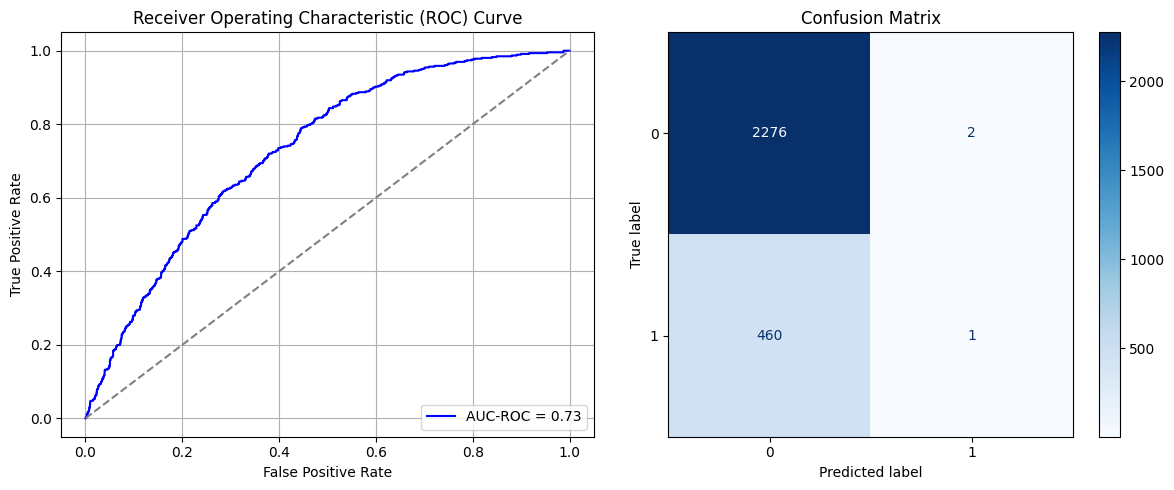

Best threshold based on F1-score: 0.22556087374687195
Time elapsed (performance): 12.919393459000275


In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_182 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_184 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_185 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_186 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_187 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_188 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - AUC: 0.7281 - loss: 0.6516 - val_AUC: 0.0000e+00 - val_loss: 0.7585
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7401 - loss: 0.5806 - val_AUC: 0.0000e+00 - val_loss: 0.7845
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7537 - loss: 0.5678 - val_AUC: 0.0000e+00 - val_loss: 0.8143
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7178 - loss: 0.5908 - val_AUC: 0.0000e+00 - val_loss: 0.8661
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7461 - loss: 0.5648 - val_AUC: 0.0000e+00 - val_loss: 0.8480
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7468 - loss: 0.5661 - val_AUC: 0.0000e+00 - val_loss: 0.7417
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7357 - loss: 0.5768 - val_AUC: 0.0000e+00 - val_loss: 0.8145
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7498 - loss: 0.5573 - val_AUC: 0.0000e+00 - val_loss: 0.7574
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

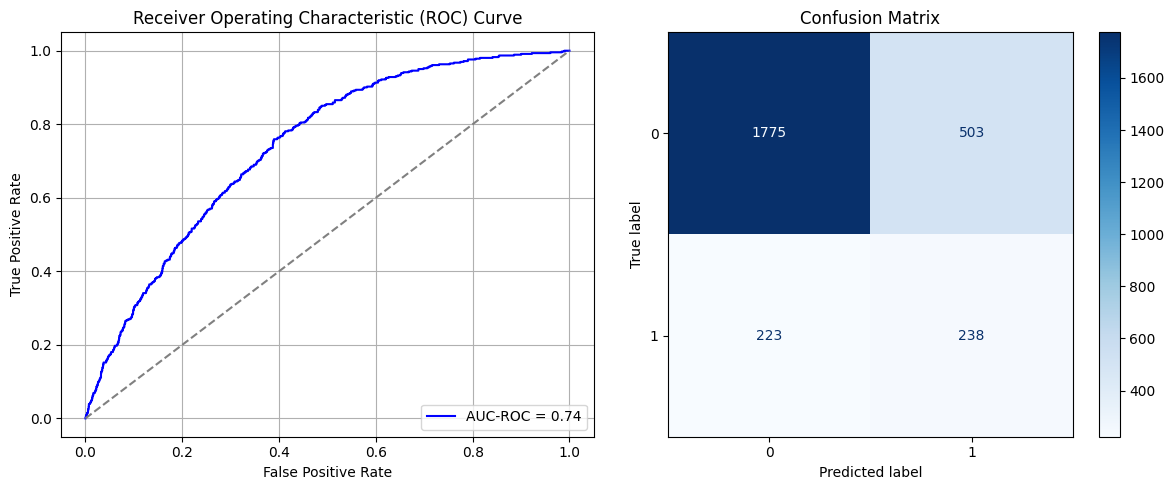

Best threshold based on F1-score: 0.370664119720459
Time elapsed (performance): 9.77788126600035


In [ ]:
fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

## Simple Random Sampling with Replacement:

In [ ]:
X_S_SRSwR, y_S_SRSwR = SRSwR_undersampler(data_S_full, data_S_full['Diabetes_binary'])
print(y_S_SRSwR)

31820
208165
19873     0
34215     0
22174     0
234103    0
145395    0
         ..
253630    1
253636    1
253659    1
253670    1
253679    1
Name: Diabetes_binary, Length: 63640, dtype: int64


In [ ]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRSwR, y_T_train_SRSwR = SRSwR_undersampler(T_train, T_train[6])
print(y_T_train_SRSwR)

1964
8992
53070     0.0
156329    0.0
29986     0.0
244955    0.0
248787    0.0
         ... 
47021     1.0
197392    1.0
59357     1.0
156689    1.0
45219     1.0
Name: 6, Length: 3928, dtype: float64


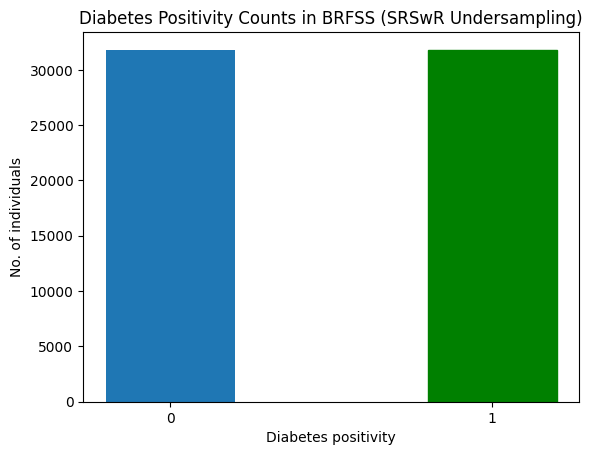

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRSwR.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRSwR Undersampling)")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50912, 20)
y_S_train: (50912,)
X_S_test: (12728, 20)
y_S_test: (12728,)


In [ ]:
model_source_SRSwR = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_189 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_190 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_191 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_192 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_193 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_194 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_195 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - AUC: 0.7682 - loss: 0.5693 - val_AUC: 0.8161 - val_loss: 0.5198
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8172 - loss: 0.5181 - val_AUC: 0.8188 - val_loss: 0.5186
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8190 - loss: 0.5155 - val_AUC: 0.8203 - val_loss: 0.5262
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8228 - loss: 0.5114 - val_AUC: 0.8198 - val_loss: 0.5233
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8260 - loss: 0.5056 - val_AUC: 0.8212 - val_loss: 0.5144
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8228 - loss: 0.5097 - val_AUC: 0.8210 - val_loss: 0.5173
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8263 - loss: 0.5062 - val_AUC: 0.8207 - val_loss: 0.5163
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8243 - loss: 0.5086 - val_AUC: 0.8221 - val_loss: 0.5228
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━

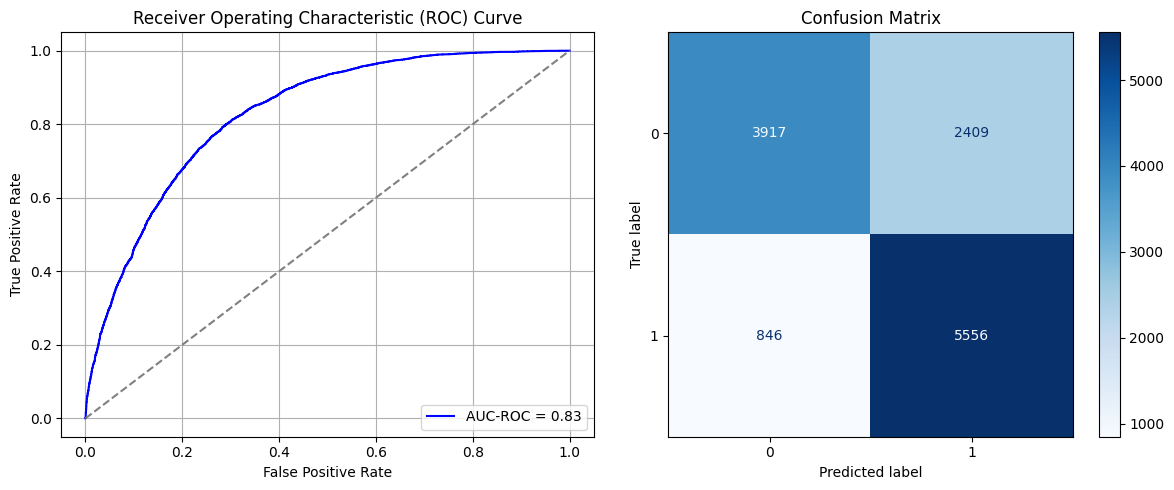

<ipython-input-14-ee81dc70d85c>:78: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Best threshold based on F1-score: 0.9875154495239258
Time elapsed (performance): 52.5868658319996


<Sequential name=sequential_27, built=True>

In [ ]:
train_and_evaluate(model_source_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.723846316459047
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.33      0.49      2278
         1.0       0.22      0.93      0.36       461

    accuracy                           0.43      2739
   macro avg       0.59      0.63      0.42      2739
weighted avg       0.84      0.43      0.47      2739

FPR 0.6716417910447762 TPR: 0.9349240780911063 FNR: 0.0650759219088937 TNR: 0.32835820895522383


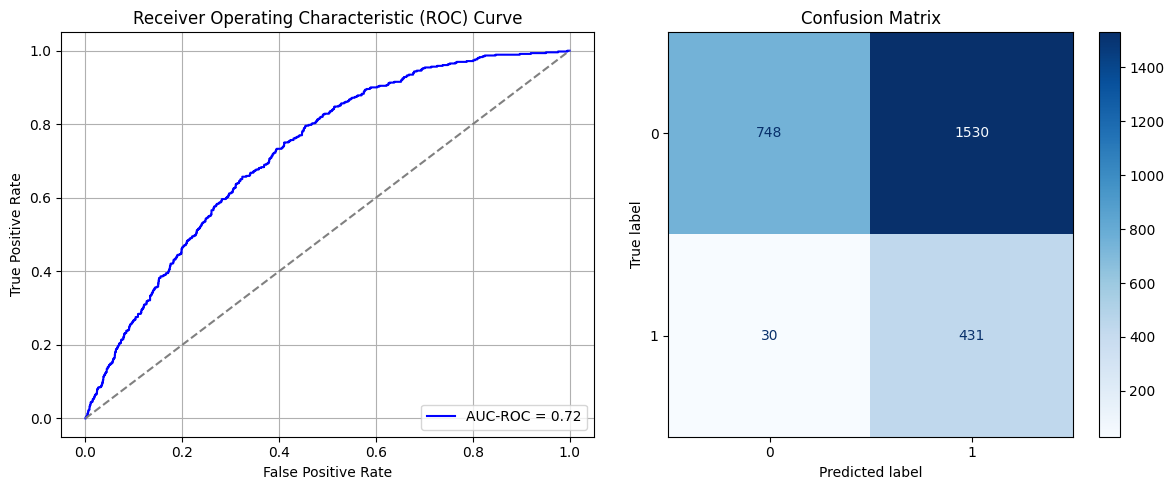

Best threshold based on F1-score: 0.7679226994514465
False Negative Rate: 0.0650759219088937
Time elapsed (performance): 0.8994784999999865


In [ ]:
Transductive_TL(model_source_SRSwR, X_T_test, y_T_test, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_196 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_197 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_198 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_199 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_200 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_201 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_202 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.6608 - loss: 0.6342 - val_AUC: 0.6947 - val_loss: 0.4582
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7055 - loss: 0.4253 - val_AUC: 0.6974 - val_loss: 0.4520
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7190 - loss: 0.4263 - val_AUC: 0.7017 - val_loss: 0.4462
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7278 - loss: 0.4094 - val_AUC: 0.7041 - val_loss: 0.4430
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7291 - loss: 0.4239 - val_AUC: 0.7071 - val_loss: 0.4409
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7268 - loss: 0.4158 - val_AUC: 0.7092 - val_loss: 0.4395
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7212 - loss: 0.4233 - val_AUC: 0.7100 - val_loss: 0.4394
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7384 - loss: 0.4140 - val_AUC: 0.7120 - val_loss: 0.4379
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7397 

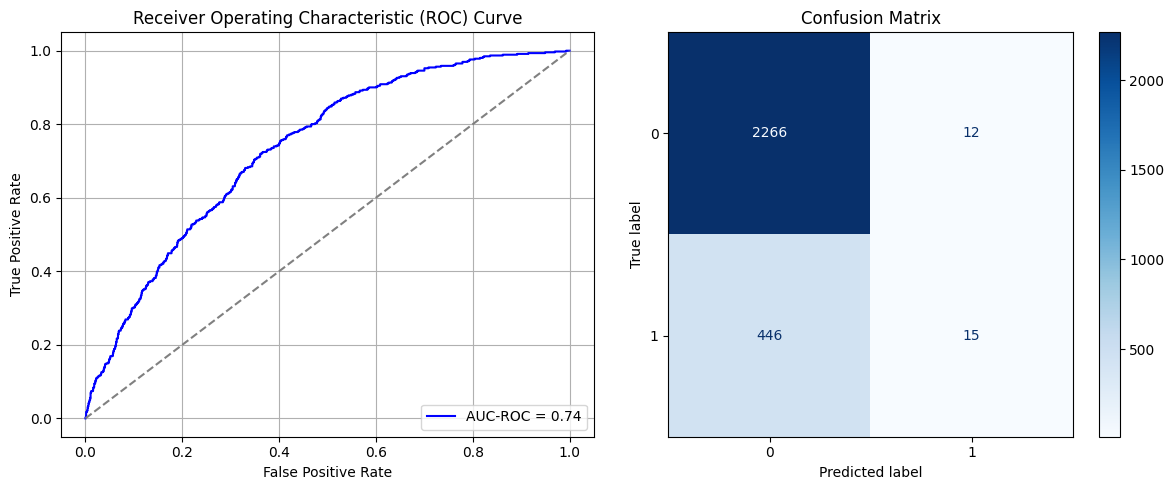

Best threshold based on F1-score: 0.21723975241184235
Time elapsed (performance): 16.34533208799985


In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_203 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_204 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_205 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_206 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_207 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_208 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_209 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - AUC: 0.6995 - loss: 0.7454 - val_AUC: 0.0000e+00 - val_loss: 0.8191
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7165 - loss: 0.5931 - val_AUC: 0.0000e+00 - val_loss: 0.8165
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7250 - loss: 0.5855 - val_AUC: 0.0000e+00 - val_loss: 0.8412
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7221 - loss: 0.5863 - val_AUC: 0.0000e+00 - val_loss: 0.8114
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7225 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.8996
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7270 - loss: 0.5848 - val_AUC: 0.0000e+00 - val_loss: 0.8720
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7173 - loss: 0.5818 - val_AUC: 0.0000e+00 - val_loss: 0.8790
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7276 - loss: 0.5754 - val_AUC: 0.0000e+00 - val_loss: 0.8191
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

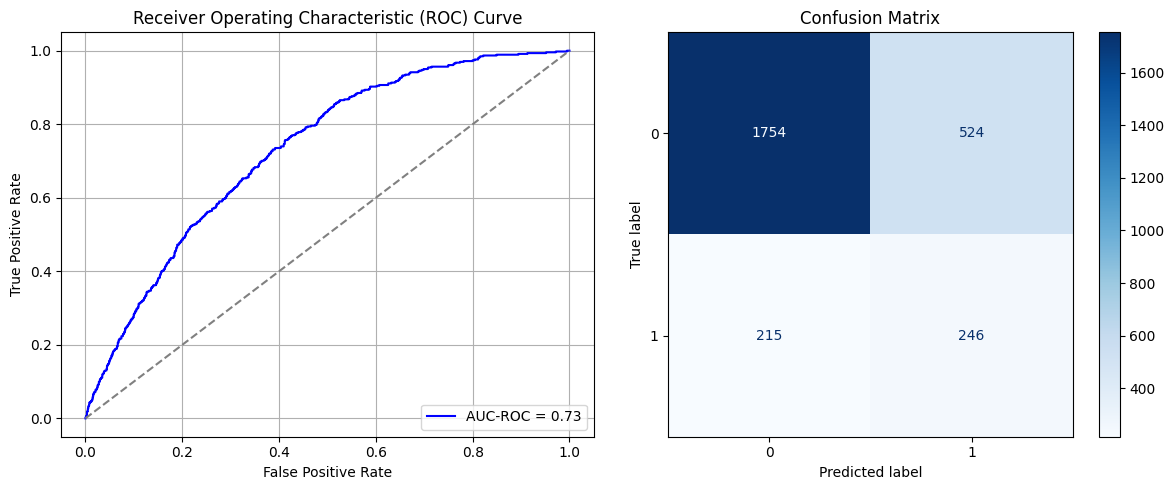

Best threshold based on F1-score: 0.5063933730125427
Time elapsed (performance): 7.784202063000066


In [ ]:
fine_tuning(X_T_train_SRSwR, X_T_test, y_T_train_SRSwR, y_T_test, 0, 4)

## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [25]:
X_S_Sy, y_S_Sy = systematic_undersampler(data_S_full, data_S_full['Diabetes_binary'])
# print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_undersampler(T_train, T_train[6])
# print(y_T_train_Sy)


31820
208165
6.5419547454431175
1
1964
8992
4.5784114052953155
2


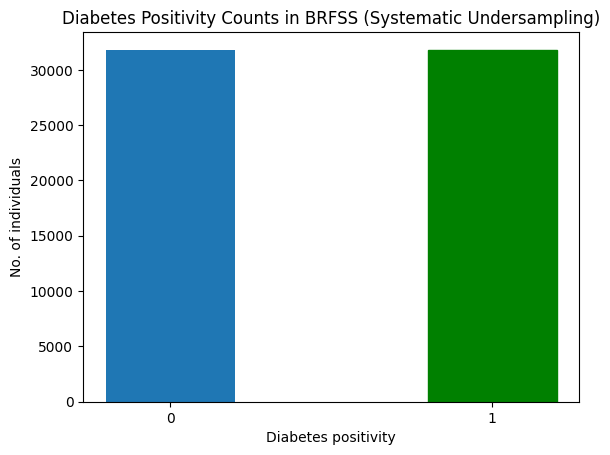

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Undersampling)")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50912, 20)
y_S_train: (50912,)
X_S_test: (12728, 20)
y_S_test: (12728,)


In [ ]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_211 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_212 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_213 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_214 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_215 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_216 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7711 - loss: 0.5660 - val_AUC: 0.8136 - val_loss: 0.5217
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.8158 - loss: 0.5190 - val_AUC: 0.8178 - val_loss: 0.5244
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8115 - loss: 0.5241 - val_AUC: 0.8168 - val_loss: 0.5344
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8201 - loss: 0.5124 - val_AUC: 0.8187 - val_loss: 0.5309
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8226 - loss: 0.5098 - val_AUC: 0.8191 - val_loss: 0.5245
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8224 - loss: 0.5107 - val_AUC: 0.8168 - val_loss: 0.5289
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8178 - loss: 0.5154 - val_AUC: 0.8208 - val_loss: 0.5206
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8253 - loss: 0.5082 - val_AUC: 0.8205 - val_loss: 0.5156
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━━

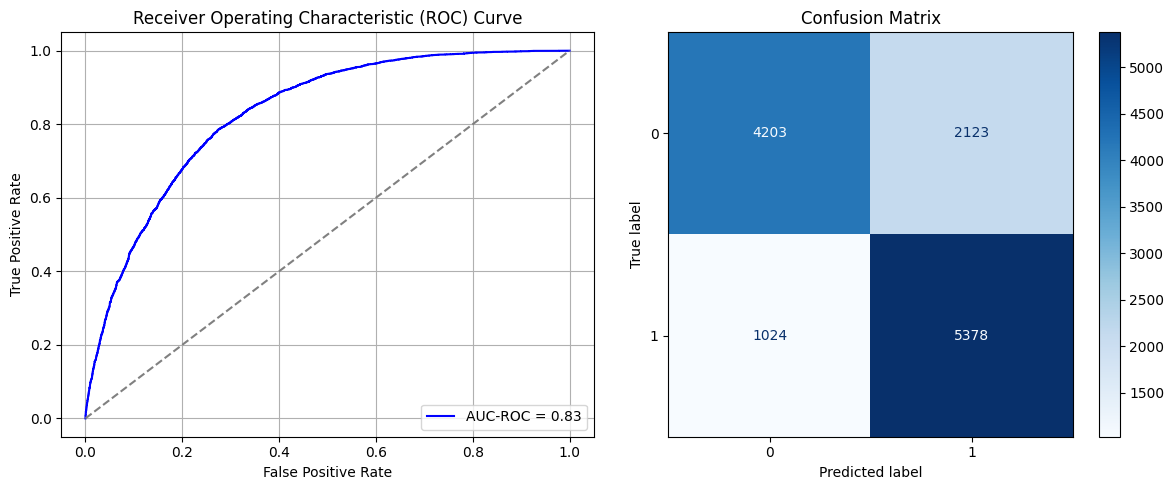

Best threshold based on F1-score: 0.443307101726532
Time elapsed (performance): 50.44845472199995


<Sequential name=sequential_30, built=True>

In [ ]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
AUC-ROC: 0.7153275983232998
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.35      0.52      2278
         1.0       0.22      0.91      0.36       461

    accuracy                           0.45      2739
   macro avg       0.59      0.63      0.44      2739
weighted avg       0.83      0.45      0.49      2739

FPR 0.6453028972783144 TPR: 0.913232104121475 FNR: 0.08676789587852494 TNR: 0.35469710272168564


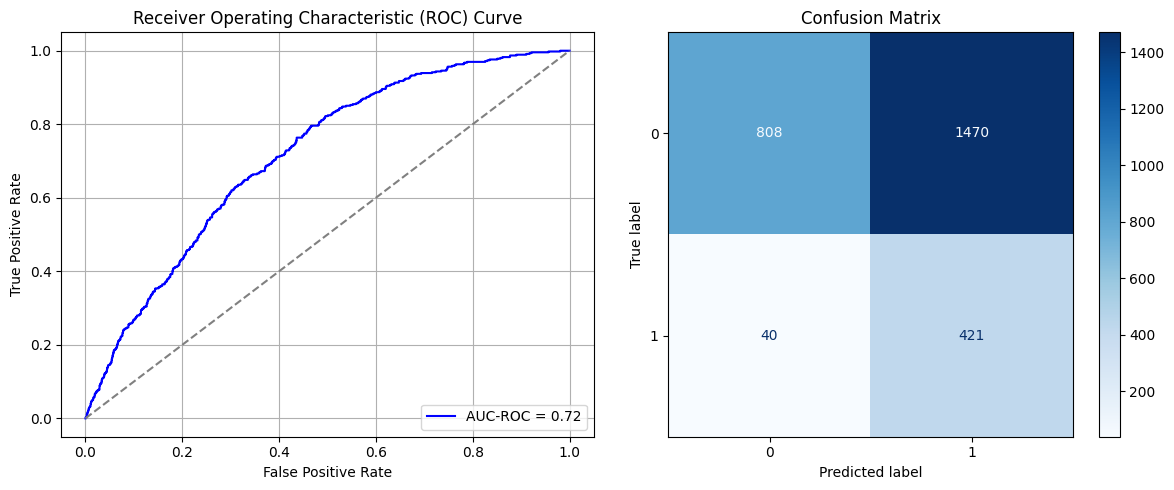

Best threshold based on F1-score: 0.7510250806808472
False Negative Rate: 0.08676789587852494
Time elapsed (performance): 0.875581038999826


In [ ]:
Transductive_TL(model_source_Sy, X_T_test, y_T_test, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_217 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_218 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_219 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_220 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_221 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_222 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_223 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.6615 - loss: 0.5972 - val_AUC: 0.7060 - val_loss: 0.4463
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7179 - loss: 0.4234 - val_AUC: 0.7061 - val_loss: 0.4413
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7262 - loss: 0.4158 - val_AUC: 0.7059 - val_loss: 0.4389
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7269 - loss: 0.4144 - val_AUC: 0.7072 - val_loss: 0.4383
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7155 - loss: 0.4169 - val_AUC: 0.7078 - val_loss: 0.4390
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7252 - loss: 0.4189 - val_AUC: 0.7083 - val_loss: 0.4390
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7202 - loss: 0.4118 - val_AUC: 0.7091 - val_loss: 0.4377
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7318 - loss: 0.4201 - val_AUC: 0.7094 - val_loss: 0.4373
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7240 -

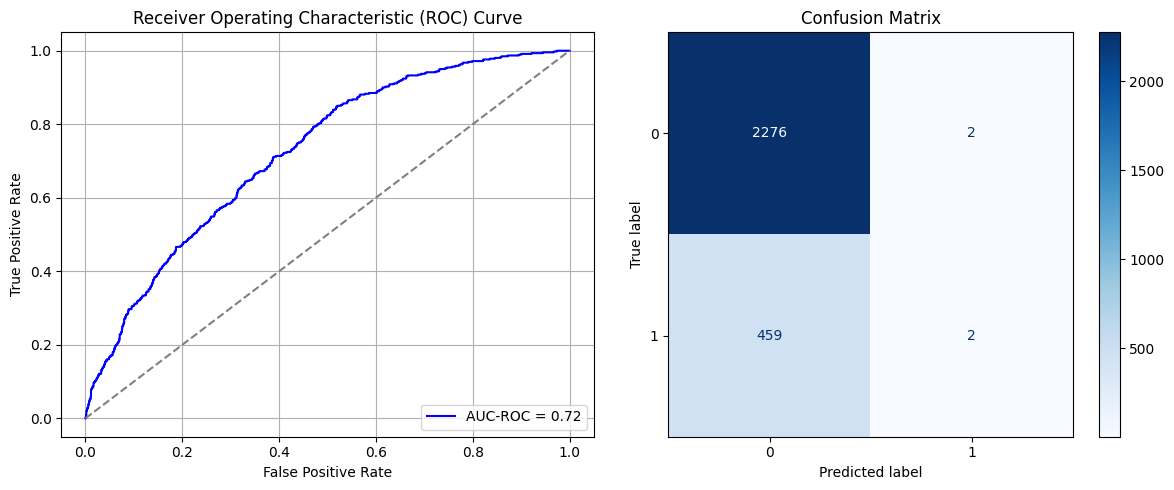

Best threshold based on F1-score: 0.20340652763843536
Time elapsed (performance): 14.88477596499979


In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_225 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_226 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_227 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_228 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_229 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_230 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - AUC: 0.7256 - loss: 0.6717 - val_AUC: 0.0000e+00 - val_loss: 0.8375
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7173 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_loss: 0.7910
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7166 - loss: 0.5965 - val_AUC: 0.0000e+00 - val_loss: 0.8172
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7260 - loss: 0.5930 - val_AUC: 0.0000e+00 - val_loss: 0.8468
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7272 - loss: 0.5851 - val_AUC: 0.0000e+00 - val_loss: 0.8268
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7224 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.7721
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7321 - loss: 0.5797 - val_AUC: 0.0000e+00 - val_loss: 0.8805
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7319 - loss: 0.5716 - val_AUC: 0.0000e+00 - val_loss: 0.8213
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

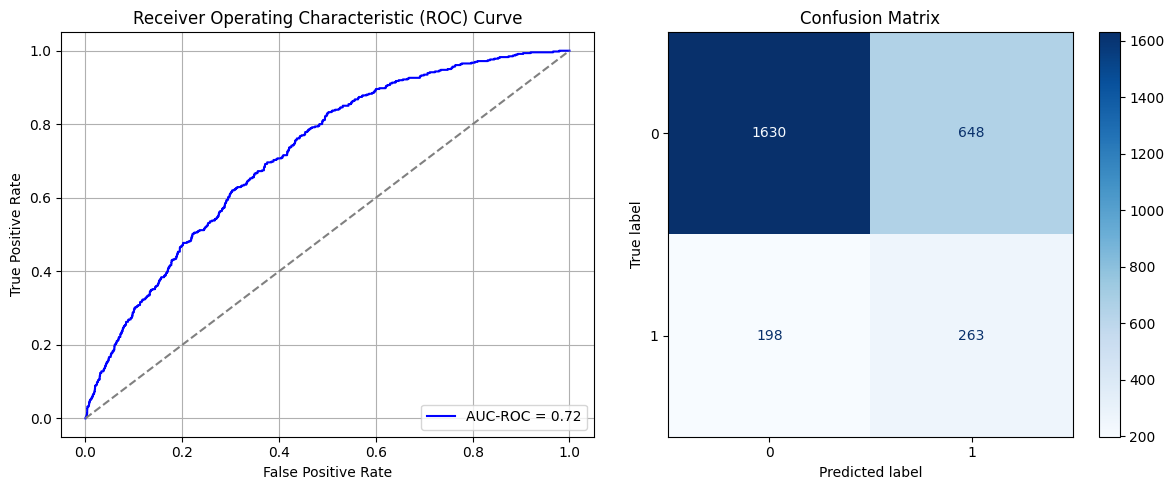

Best threshold based on F1-score: 0.4870089888572693
Time elapsed (performance): 7.166785033999986


In [ ]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [29]:
X_S_Sy, y_S_Sy = multi_systematic_undersampler(data_S_full, data_S_full['Diabetes_binary'], 10)
# print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = multi_systematic_undersampler(T_train, T_train[6], 10)
# print(y_T_train_Sy)

31820
208165
6.5419547454431175
1964
8992
4.5784114052953155


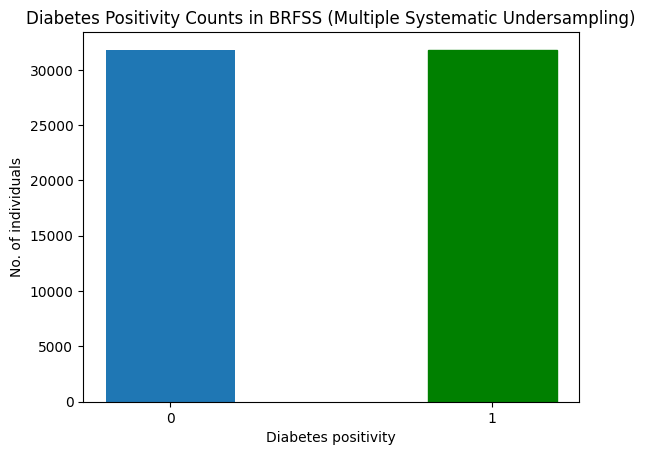

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Multiple Systematic Undersampling)")
plt.show()

In [ ]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50912, 20)
y_S_train: (50912,)
X_S_test: (12728, 20)
y_S_test: (12728,)


In [ ]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_231 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_232 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_233 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_234 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_235 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_236 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_237 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.7799 - loss: 0.5620 - val_AUC: 0.8216 - val_loss: 0.5184
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8216 - loss: 0.5104 - val_AUC: 0.8278 - val_loss: 0.5073
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8259 - loss: 0.5063 - val_AUC: 0.8288 - val_loss: 0.5081
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8302 - loss: 0.5003 - val_AUC: 0.8278 - val_loss: 0.5069
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8274 - loss: 0.5044 - val_AUC: 0.8287 - val_loss: 0.5052
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8315 - loss: 0.4980 - val_AUC: 0.8296 - val_loss: 0.5097
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8318 - loss: 0.4997 - val_AUC: 0.8299 - val_loss: 0.5054
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8369 - loss: 0.4922 - val_AUC: 0.8301 - val_loss: 0.5023
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━━

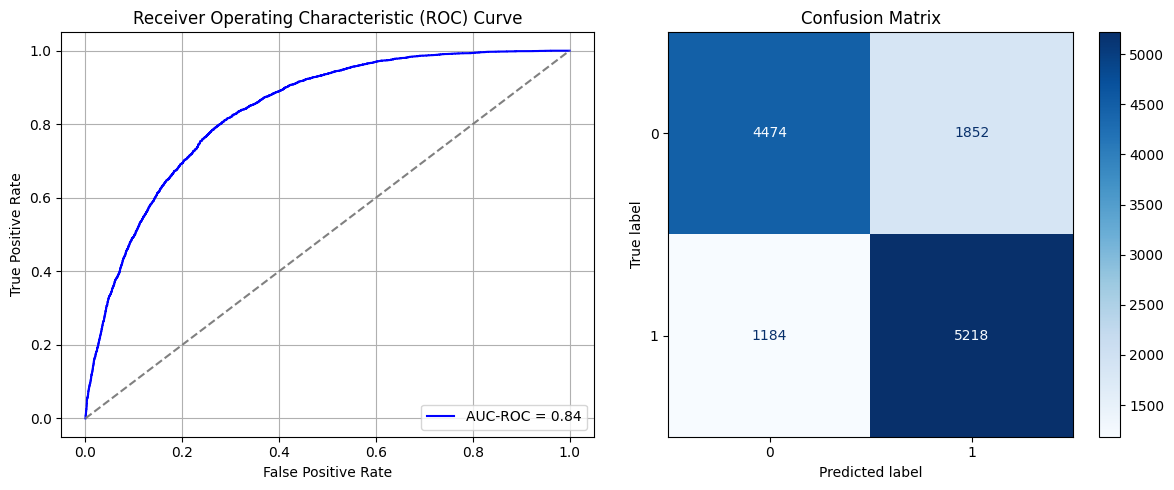

Best threshold based on F1-score: 0.3553787171840668
Time elapsed (performance): 50.57199583500005


<Sequential name=sequential_33, built=True>

In [ ]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.7086971674738468
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.38      0.55      2278
         1.0       0.23      0.90      0.36       461

    accuracy                           0.47      2739
   macro avg       0.59      0.64      0.46      2739
weighted avg       0.83      0.47      0.52      2739

FPR 0.6150131694468832 TPR: 0.9002169197396963 FNR: 0.09978308026030369 TNR: 0.3849868305531168


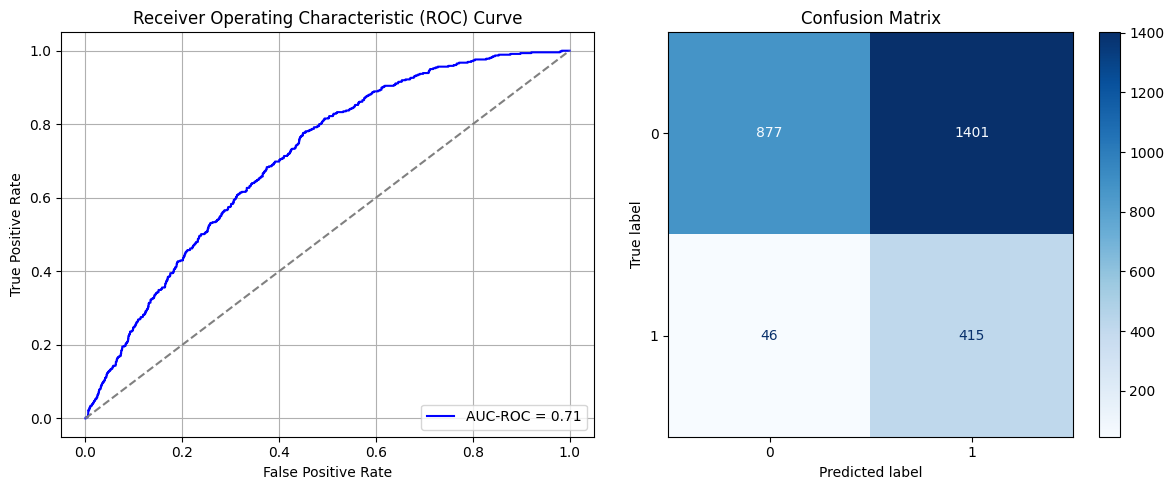

Best threshold based on F1-score: 0.6682840585708618
False Negative Rate: 0.09978308026030369
Time elapsed (performance): 0.8387884829999166


In [ ]:
Transductive_TL(model_source_Sy, X_T_test, y_T_test, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_238 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_239 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_240 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_241 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_242 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_243 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_244 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - AUC: 0.6570 - loss: 0.6177 - val_AUC: 0.6974 - val_loss: 0.4508
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7131 - loss: 0.4239 - val_AUC: 0.7001 - val_loss: 0.4460
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7144 - loss: 0.4187 - val_AUC: 0.7026 - val_loss: 0.4431
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7146 - loss: 0.4284 - val_AUC: 0.7042 - val_loss: 0.4421
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7127 - loss: 0.4235 - val_AUC: 0.7081 - val_loss: 0.4406
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7212 - loss: 0.4201 - val_AUC: 0.7083 - val_loss: 0.4398
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7294 - loss: 0.4169 - val_AUC: 0.7124 - val_loss: 0.4381
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7302 - loss: 0.4124 

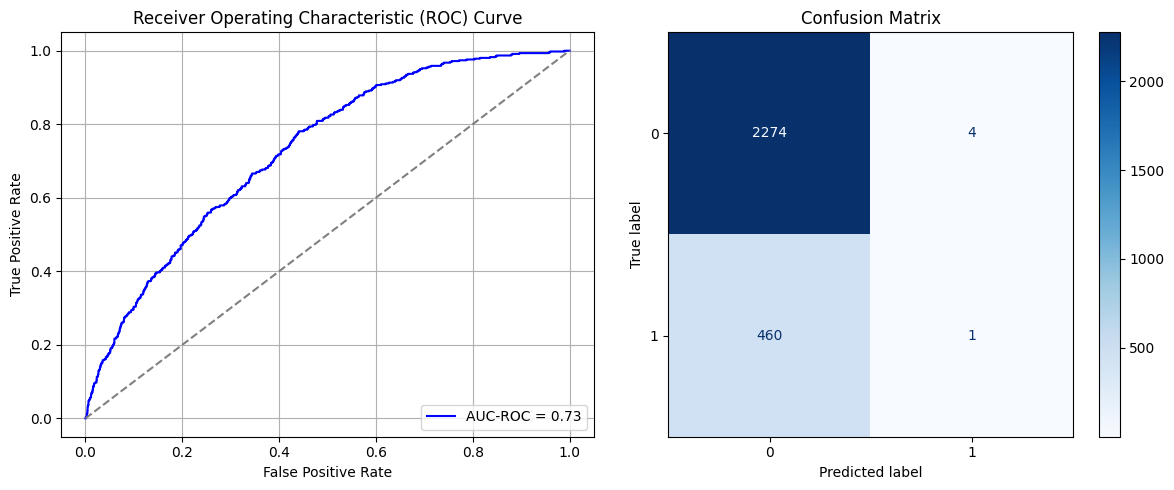

Best threshold based on F1-score: 0.2234957218170166
Time elapsed (performance): 22.009680127000138


In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_266 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_267 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_268 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_269 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_270 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_271 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_272 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - AUC: 0.7063 - loss: 0.6915 - val_AUC: 0.0000e+00 - val_loss: 0.8392
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7225 - loss: 0.5999 - val_AUC: 0.0000e+00 - val_loss: 0.8617
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7097 - loss: 0.5949 - val_AUC: 0.0000e+00 - val_loss: 0.8806
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7043 - loss: 0.6014 - val_AUC: 0.0000e+00 - val_loss: 0.7888
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7117 - loss: 0.5896 - val_AUC: 0.0000e+00 - val_loss: 0.8018
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7314 - loss: 0.5803 - val_AUC: 0.0000e+00 - val_loss: 0.8175
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7144 - loss: 0.5878 - val_AUC: 0.0000e+00 - val_loss: 0.8497
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7420 - loss: 0.5687 - val_AUC: 0.0000e+00 - val_loss: 0.8498
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

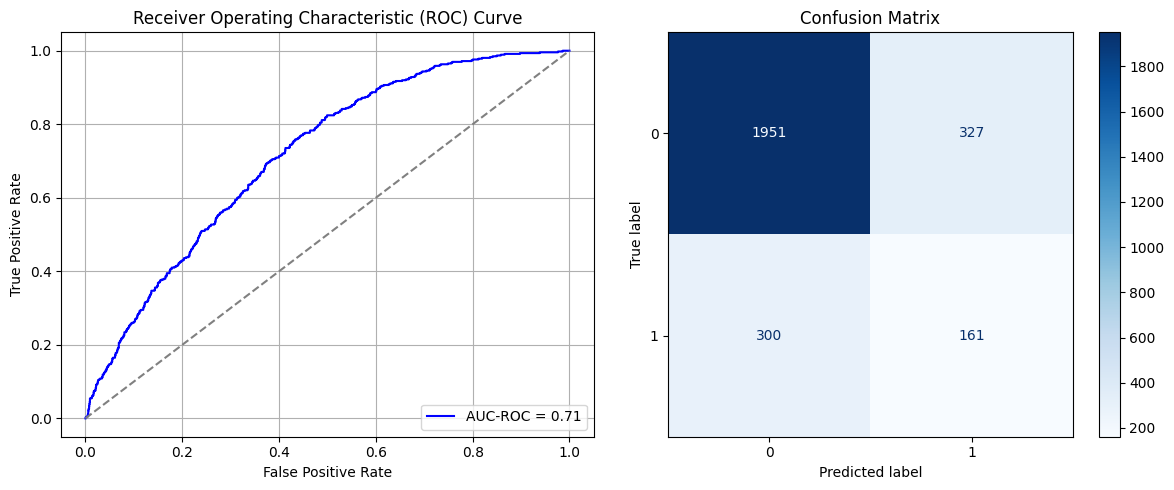

Best threshold based on F1-score: 0.38520047068595886
Time elapsed (performance): 7.195797791000132


In [ ]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)

# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [ ]:
X_S_SRS, y_S_SRS = SRSwR_oversampler(data_S_full, data_S_full['Diabetes_binary'])
print(y_S_SRS)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_SRS, y_T_train_SRS = SRSwR_oversampler(T_train, T_train[6])
print(y_T_train_Sy)

31820
208165
0         0
1         0
2         0
4         0
5         0
         ..
41447     1
20037     1
174108    1
225124    1
153448    1
Name: Diabetes_binary, Length: 416330, dtype: int64
1964
8992
158309    0.0
13771     0.0
94673     0.0
178385    0.0
212537    0.0
         ... 
47021     1.0
197392    1.0
59357     1.0
156689    1.0
45219     1.0
Name: 6, Length: 3924, dtype: float64


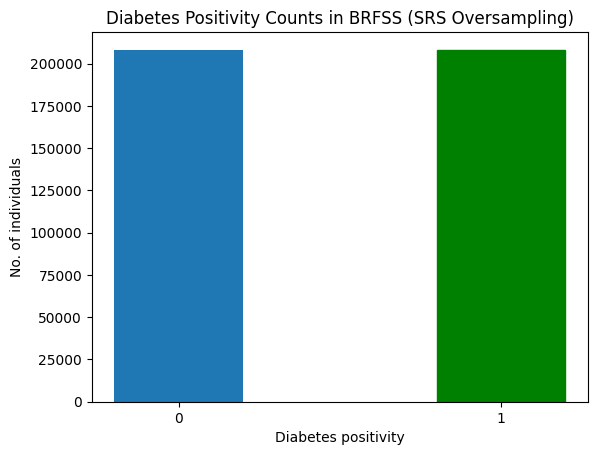

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Oversampling)")
plt.show()

In [ ]:
model_source_SRS_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_274 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_275 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_276 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_277 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_278 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_279 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7864 - loss: 0.5540 - val_AUC: 0.8221 - val_loss: 0.5135
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8243 - loss: 0.5074 - val_AUC: 0.8265 - val_loss: 0.5075
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8281 - loss: 0.5044 - val_AUC: 0.8268 - val_loss: 0.5077
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8292 - loss: 0.5032 - val_AUC: 0.8281 - val_loss: 0.5060
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8319 - loss: 0.4997 - val_AUC: 0.8271 - val_loss: 0.5067
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8323 - loss: 0.4977 - val_AUC: 0.8292 - val_loss: 0.5051
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8334 - loss: 0.4977 - val_AUC: 0.8301 - val_loss: 0.5079
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8345 - loss: 0.4963 - val_AUC: 0.8301 - val_loss: 0.5082
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━━

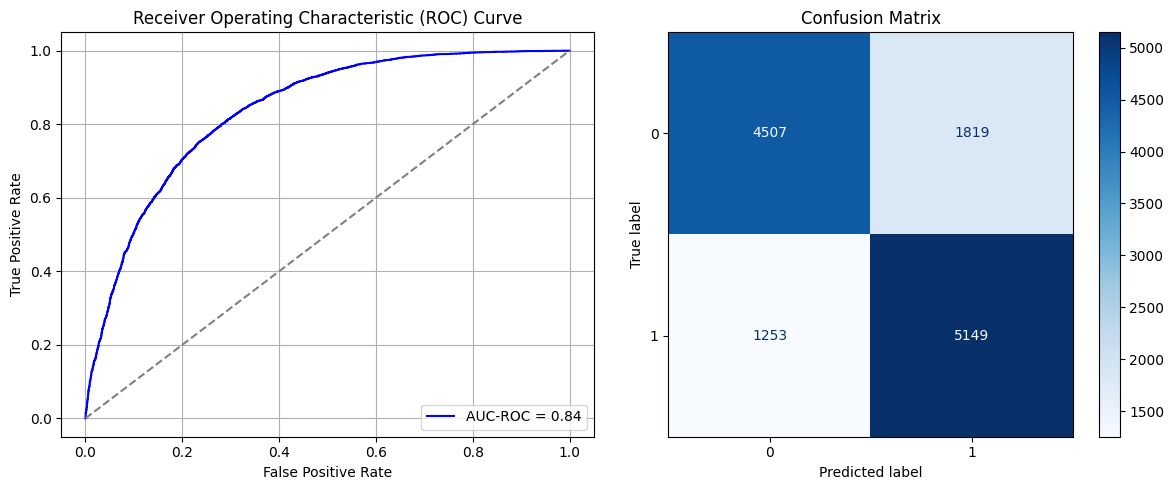

Best threshold based on F1-score: 0.37322863936424255
Time elapsed (performance): 47.14994114499996


<Sequential name=sequential_39, built=True>

In [ ]:
train_and_evaluate(model_source_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.6982892098141422
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.38      0.54      2278
         1.0       0.23      0.89      0.36       461

    accuracy                           0.47      2739
   macro avg       0.58      0.63      0.45      2739
weighted avg       0.82      0.47      0.51      2739

FPR 0.6176470588235294 TPR: 0.8872017353579176 FNR: 0.11279826464208242 TNR: 0.38235294117647056


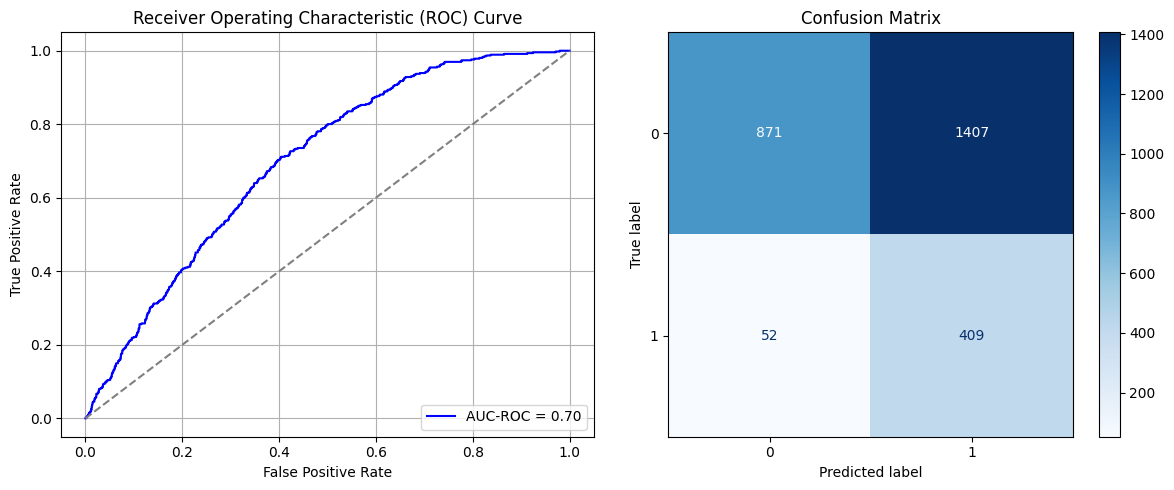

Best threshold based on F1-score: 0.7198267579078674
False Negative Rate: 0.11279826464208242
Time elapsed (performance): 1.078117169000052


In [ ]:
Transductive_TL(model_source_SRS_ROS, X_T_test, y_T_test, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_281 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_282 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_283 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_284 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_285 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_286 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - AUC: 0.6548 - loss: 0.6199 - val_AUC: 0.6789 - val_loss: 0.4534
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.6984 - loss: 0.4271 - val_AUC: 0.6850 - val_loss: 0.4484
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6980 - loss: 0.4270 - val_AUC: 0.6876 - val_loss: 0.4463
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7101 - loss: 0.4198 - val_AUC: 0.6910 - val_loss: 0.4457
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7070 - loss: 0.4257 - val_AUC: 0.6907 - val_loss: 0.4463
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7046 - loss: 0.4290 - val_AUC: 0.6924 - val_loss: 0.4449
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7212 - loss: 0.4054 - val_AUC: 0.6934 - val_loss: 0.4448
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7120 - loss: 0.4256 - val_AUC: 0.6953 - val_loss: 0.4425
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7240 

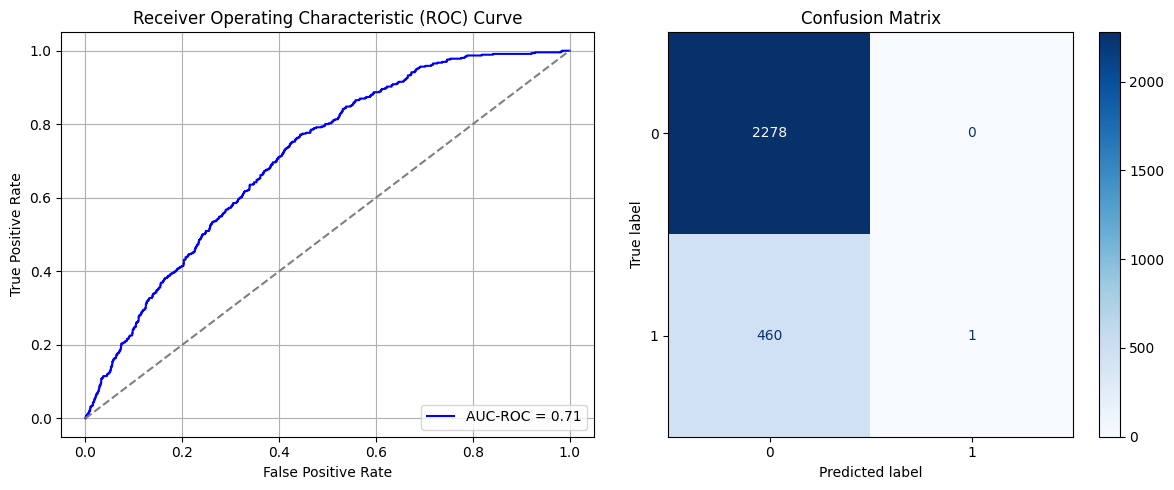

Best threshold based on F1-score: 0.1873495876789093
Time elapsed (performance): 16.899256394000076


In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_294 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_295 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_296 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_297 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_298 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_299 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_300 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.6873 - loss: 0.6411 - val_AUC: 0.0000e+00 - val_loss: 0.8157
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6962 - loss: 0.5998 - val_AUC: 0.0000e+00 - val_loss: 0.8232
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7035 - loss: 0.5941 - val_AUC: 0.0000e+00 - val_loss: 0.8927
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7217 - loss: 0.5778 - val_AUC: 0.0000e+00 - val_loss: 0.8913
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7124 - loss: 0.5897 - val_AUC: 0.0000e+00 - val_loss: 0.9204
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7111 - loss: 0.5873 - val_AUC: 0.0000e+00 - val_loss: 0.8125
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7220 - loss: 0.5807 - val_AUC: 0.0000e+00 - val_loss: 0.8932
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7183 - loss: 0.5822 - val_AUC: 0.0000e+00 - val_loss: 0.8683
Epoch 9/10
450/450 ━━━━━━━━━━━━━━━━

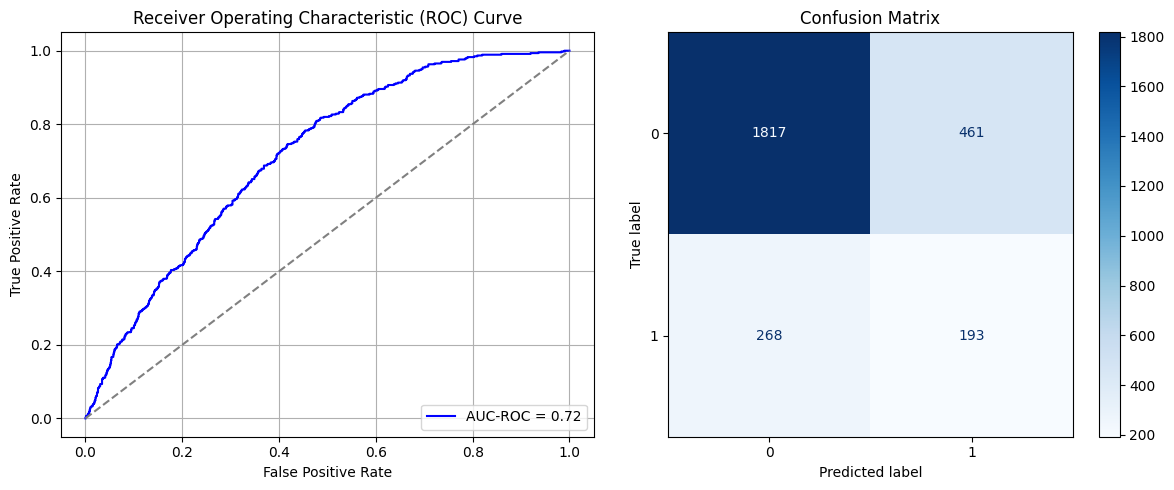

Best threshold based on F1-score: 0.416156530380249
Time elapsed (performance): 17.682234864999828


In [ ]:
fine_tuning(X_T_train_SRS, X_T_test, y_T_train_SRS, y_T_test, 0, 4)

## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, taking $k=48$ yields a number of samples of $k*\frac{N_0-N_1}{N_1}=266.01 \approx 266$, so we take $k=48$ for the source data resampling. Similarly, we take $k=50$ for the target training data resampling, as this yields a $k*\frac{N_0-N_1}{N_1}=178.92 \approx 179$.

In [26]:
X_S_Sy, y_S_Sy = systematic_resampler(data_S_full, data_S_full['Diabetes_binary'], 48)
print(y_S_Sy)

X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(data_T_X, data_T_y, test_size=0.20, random_state=0)
T_train = pd.concat([X_T_train, y_T_train], axis=1)

X_T_train_Sy, y_T_train_Sy = systematic_resampler(T_train, T_train[6], 50)
print(y_T_train_Sy)

31820
208165
Nsamples= 266.01382778126964
0         0
1         0
2         0
4         0
5         0
         ..
251761    1
252023    1
252421    1
252732    1
253055    1
Name: Diabetes_binary, Length: 416077, dtype: int64
1964
8992
Nsamples= 178.9205702647658
126273    0.0
191397    0.0
158309    0.0
83510     0.0
194674    0.0
         ... 
136684    1.0
59235     1.0
84125     1.0
180511    1.0
78825     1.0
Name: 6, Length: 17898, dtype: float64


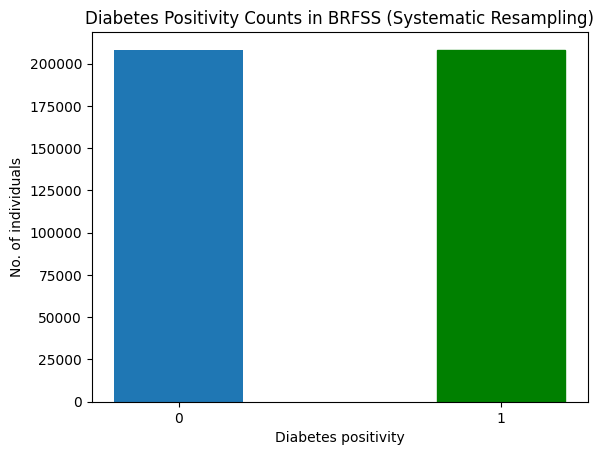

In [ ]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Resampling)")
plt.show()

In [ ]:
model_source_Sy_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_301 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_302 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_303 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_304 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_305 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_306 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_307 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7


Epoch 1/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - AUC: 0.8100 - loss: 0.5263 - val_AUC: 0.8260 - val_loss: 0.5080
Epoch 2/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8251 - loss: 0.5078 - val_AUC: 0.8268 - val_loss: 0.5066
Epoch 3/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8299 - loss: 0.5019 - val_AUC: 0.8288 - val_loss: 0.5039
Epoch 4/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8303 - loss: 0.5014 - val_AUC: 0.8286 - val_loss: 0.5099
Epoch 5/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8309 - loss: 0.5002 - val_AUC: 0.8292 - val_loss: 0.5032
Epoch 6/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - AUC: 0.8322 - loss: 0.4976 - val_AUC: 0.8305 - val_loss: 0.5020
Epoch 7/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - AUC: 0.8325 - loss: 0.4969 - val_AUC: 0.8318 - val_loss: 0.4997
Epoch 8/10
8322/8322 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - AUC: 0.8349 - loss: 0.4943 - val_AUC: 0.8305 - val_loss: 0.5004
Epoch 9/10
8322/8322 ━━━━━━━━━━━

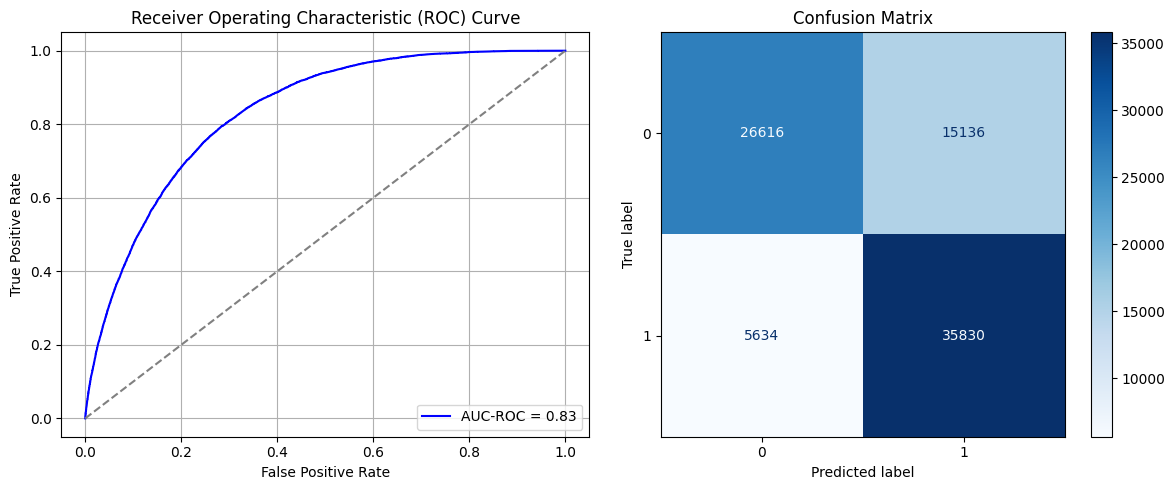

Best threshold based on F1-score: 0.4893786609172821
Time elapsed (performance): 314.3521176549998


<Sequential name=sequential_43, built=True>

In [ ]:
train_and_evaluate(model_source_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC-ROC: 0.7143801218483314
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.34      0.50      2278
         1.0       0.22      0.92      0.36       461

    accuracy                           0.44      2739
   macro avg       0.59      0.63      0.43      2739
weighted avg       0.83      0.44      0.48      2739

FPR 0.6571553994732221 TPR: 0.9219088937093276 FNR: 0.07809110629067245 TNR: 0.3428446005267779


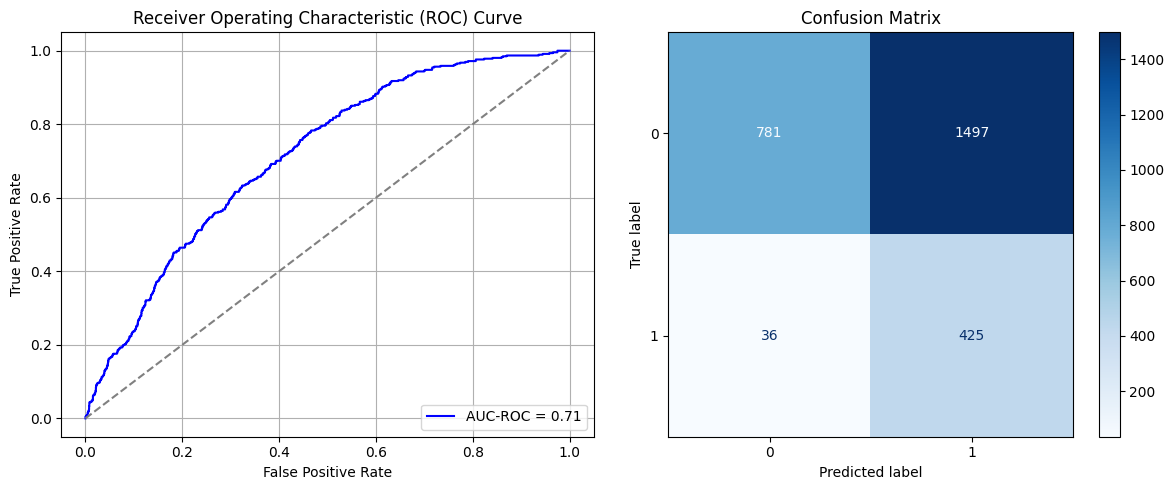

Best threshold based on F1-score: 0.7622153162956238
False Negative Rate: 0.07809110629067245
Time elapsed (performance): 0.7889859030001389


In [ ]:
Transductive_TL(model_source_Sy_ROS, X_T_test, y_T_test, "Target")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_308 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_309 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_310 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_311 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_312 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_313 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_314 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - AUC: 0.6622 - loss: 0.7220 - val_AUC: 0.6384 - val_loss: 0.4660
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6770 - loss: 0.4563 - val_AUC: 0.6892 - val_loss: 0.4491
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7306 - loss: 0.4217 - val_AUC: 0.6950 - val_loss: 0.4436
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7196 - loss: 0.4204 - val_AUC: 0.6964 - val_loss: 0.4427
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7253 - loss: 0.4119 - val_AUC: 0.6969 - val_loss: 0.4431
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7210 - loss: 0.4226 - val_AUC: 0.6983 - val_loss: 0.4425
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7213 - loss: 0.4216 - val_AUC: 0.6986 - val_loss: 0.4418
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7214 - loss: 0.4162 - val_AUC: 0.7002 - val_loss: 0.4418
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7103 -

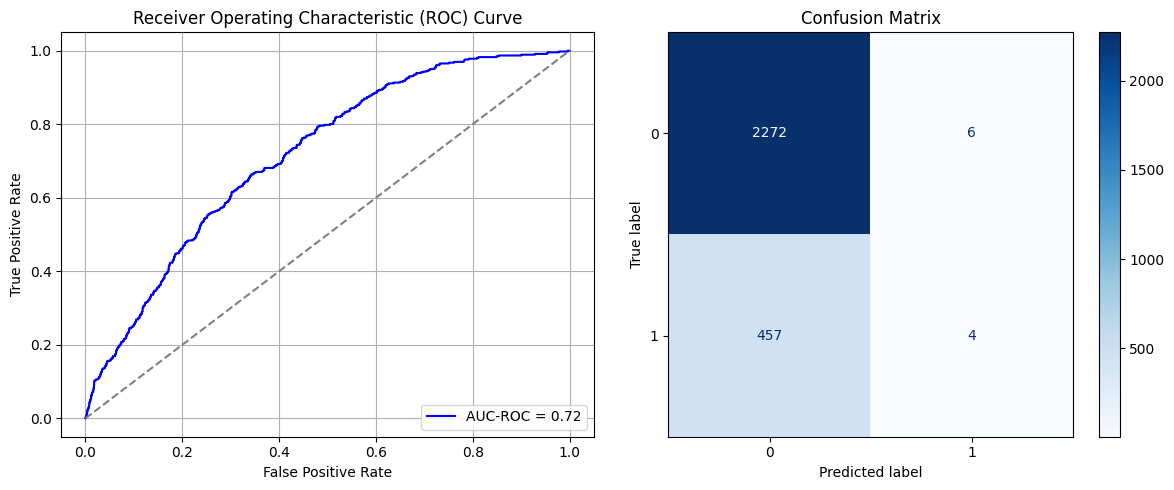

Best threshold based on F1-score: 0.5816814303398132
Time elapsed (performance): 14.856687397000314


<ipython-input-15-4d6e0a8435db>:50: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
fine_tuning(X_T_train, X_T_test, y_T_train, y_T_test, 0, 4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)                    │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_316 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_317 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_318 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_319 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_320 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_321 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

7
Not Trainable
Not Trainable
Not Trainable
Not Trainable
Trainable
Trainable
Not Trainable
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.6805 - loss: 0.6828 - val_AUC: 0.0000e+00 - val_loss: 0.8316
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7121 - loss: 0.5962 - val_AUC: 0.0000e+00 - val_loss: 0.8754
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7128 - loss: 0.5864 - val_AUC: 0.0000e+00 - val_loss: 0.8415
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7154 - loss: 0.5849 - val_AUC: 0.0000e+00 - val_loss: 0.8420
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7132 - loss: 0.5837 - val_AUC: 0.0000e+00 - val_loss: 0.8266
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7200 - loss: 0.5800 - val_AUC: 0.0000e+00 - val_loss: 0.9098
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7175 - loss: 0.5840 - val_AUC: 0.0000e+00 - val_loss: 0.8850
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7200 - loss: 0.5783 - val_AUC: 0.0000e+00 - val_loss: 0.8371
Epoch 9/10
448/448 ━━━━━━━━━━━━━━━━

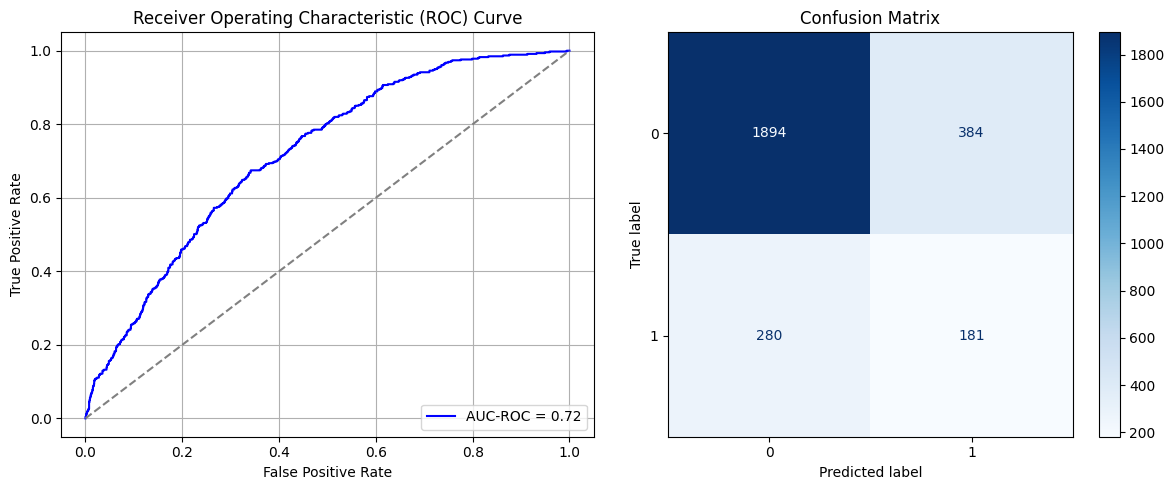

Best threshold based on F1-score: 0.411687433719635
Time elapsed (performance): 19.22237917099983


In [ ]:
fine_tuning(X_T_train_Sy, X_T_test, y_T_train_Sy, y_T_test, 0, 4)